In [1]:
import keras 
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#import cv2 as cv

In [3]:
## load the alzheimers dataset
def load_data(test_split = 0.3):
    
    ## (1) Data preparation
    df=pd.read_csv('AlzData.csv', sep = ',')
    print(df)
    
    # rm ids, rm targets
    transposedDataFrameVals = df.values.T[1:-1].astype('float32')
    #walk thru features
    for i, row in enumerate(transposedDataFrameVals):
        #normalize data [0,1]
        transposedDataFrameVals[i] = row / max(row)
    
    #assign normalized data
    X = transposedDataFrameVals.T
    
    #assign targets
    targets = df.values.T[-1]
    #conv to binary target
    Y = np.array( [1 if target == 'P' else 0 for target in targets] )

    # data split of 70 training and 30 test
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split)
        
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

print('Data shape:', 'x_train:', x_train.shape, 'x_test:', x_test.shape)
print('Data shape:', 'y_train:', y_train.shape, 'y_test:', y_test.shape)


         ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0      id_1       5160     0.000013    120.804174       86.853334   
1      id_2      51980     0.000016    115.318238       83.448681   
2      id_3       2600     0.000010    229.933997      172.761858   
3      id_4       2130     0.000010    369.403342      183.193104   
4      id_5       2310     0.000007    257.997131      111.275889   
..      ...        ...          ...           ...             ...   
169  id_170       2930     0.000010    241.736477      176.115957   
170  id_171       2140     0.000009    274.728964      234.495802   
171  id_172       3830     0.000008    151.536989      171.104693   
172  id_173       1760     0.000008    289.518195      196.411138   
173  id_174       2875     0.000008    235.769350      178.208024   

     max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0                 957              6601          0.361800            0.217459   
1        

In [13]:
# Create a Fully Connected NN

features = x_train.shape[1]
hidden_nodes = (64, 32)

model_fcn = keras.Sequential()

hiddenLayers = []

h_layer = layers.Dense(
    input_dim=features,
    units=hidden_nodes[0],
    activation=activations.relu,
)
hiddenLayers.append(h_layer)
model_fcn.add(h_layer)

h_layer = layers.Dense(
    input_dim=features,
    units=hidden_nodes[1],
    activation=activations.relu,
)
hiddenLayers.append(h_layer)
model_fcn.add(h_layer)

o_layer = layers.Dense(
    input_dim=hidden_nodes[0],
    units=1,
    activation=activations.softmax,
)
model_fcn.add(o_layer)

#need normalization and output layers

#specify optimization
model_fcn.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

model_fcn.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                28864     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,977
Trainable params: 30,977
Non-trainable params: 0
_________________________________________________________________


In [15]:
[print(i.shape, i.dtype) for i in model_fcn.inputs]
[print(o.shape, o.dtype) for o in model_fcn.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model_fcn.layers]

#train model
history = model_fcn.fit(
    x_train, 
    y_train, #already onehot
    batch_size=2,
    epochs=50,
    verbose=1,
    validation_split=0.2,
)

(None, 450) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
dense_8 (None, 450) float32
dense_9 (None, 64) float32
dense_10 (None, 32) float32
Epoch 1/50
48/48 [==============================] - 0s 8ms/step - loss: 0.1745 - accuracy: 0.5000 - val_loss: 0.3294 - val_accuracy: 0.4800
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.5000 - val_loss: 0.4295 - val_accuracy: 0.4800
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0705 - accuracy: 0.5000 - val_loss: 0.3461 - val_accuracy: 0.4800
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0537 - accuracy: 0.5000 - val_loss: 0.3575 - val_accuracy: 0.4800
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.5000 - val_loss: 0.4236 - val_accuracy: 0.4800
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.5000 - val_loss: 0.4143 - val_accuracy: 0.4800
Epoch 7/50
48/48 

In [25]:
#test accuracy
y_test_pred = model_fcn.predict(x_test)[:, 0] #cutoff last dim bc useless
truePreds = np.sum(y_test == y_test_pred)
test_acc = truePreds / y_test.shape[0]

print(f'test accuracy: {test_acc * 100}')

2/2 [==============================] - 0s 3ms/step
test accuracy: 54.71698113207547


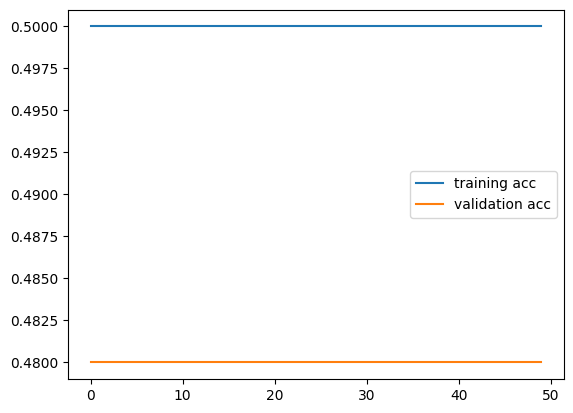

In [27]:
#history of training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training acc', 'validation acc'])
plt.show()

In [28]:
#get access to filters/kernels
weights = hiddenLayers[0].get_weights()[0][:, :, 0, :] #arr of a buncha nested lists, 0 bc only have 1 channel (28, 28, 1, 8)

#can get access to other params this way 

for i in range(1, 8):
    plt.subplot(2, 4, i)
    plt.imshow(weights[:,:,i], cmap="gray")
plt.show()

#how get access to feature maps?

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed